In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import statistics
#from function import *
import statsmodels.api as sm
from datetime import datetime, timedelta
import time
from btbase import *

In [2]:
class train:
    
    # 初始化
    def __init__(self):
        self.dataframe = None
        self.data_laundry = None
        self.start_time = None
        self.end_time = None
        self.sigma_delta_price = None
    
    # 通过平台api获取数据
    def set_data(self, s_time, e_time, symbols='btc/usdt.spot.binance', fields=None, bar_type="1m", offset=None, engine_info=None):
        # 获取数据api
        self.dataframe = get_crypto_price(s_time, e_time, symbols=symbol_, fields=None, bar_type="1m", offset=None, engine_info=None)
        # 把收益率加入到dataframe中
        self.dataframe = self.dataframe.assign(return_close= self.dataframe['close'].pct_change() * 100)

        self.dataframe = self.dataframe.assign(delta_price = self.dataframe['close'] - self.dataframe['close'].shift(1)) 

        self.sigma_delta_price = np.std(self.dataframe['delta_price'])
        # 获取数据的开始时间
        self.start_time = self.dataframe['e_date'].iloc[0]
        # 获取数据的结束时间
        self.end_time = self.dataframe['e_date'].iloc[-1]
    
    # 通过dataframe文件获取数据
    def set_data_df(self, dataframe):
        # 本地dataframe
        self.dataframe = dataframe.copy()
        
        # 把收益率加入到dataframe中 
        self.dataframe = self.dataframe.assign(return_close = self.dataframe['close'].pct_change() * 100) 

        self.dataframe = self.dataframe.assign(delta_price = self.dataframe['close'] - self.dataframe['close'].shift(1)) 

        self.sigma_delta_price = np.std(self.dataframe['delta_price'])
        # 获取数据的开始时间
        self.start_time = self.dataframe['e_date'].iloc[0] 
        # 获取数据的结束时间
        self.end_time = self.dataframe['e_date'].iloc[-1]
        
    
    # 方程用来得到相应步长的volatility
    def get_volatility(self, time_step):
        # 倒序向前60分钟 作为每个区间的endtime
        time_range = pd.date_range(start=self.end_time , end=self.start_time, freq = timedelta(minutes = -60))
        # 建立dataframe
        hour_table = pd.DataFrame({'hour_e_time': time_range})
        # 根据time_step确定每个区间长度
        hour_table.insert(0, 'hour_s_time' , time_range + timedelta(minutes = - time_step))
        volatility = []
        # 在dataframe中取出相应区间的收益率并计算标准差得到volatility
        for i in hour_table.index:
            volatility.append(np.std(self.dataframe['return_close'][(self.dataframe.e_date > hour_table.hour_s_time[i]) & (self.dataframe.e_date <=  hour_table.hour_e_time[i])].dropna()))
        # 加入dataframe
        hour_table['volatility'] = volatility
        # 换成顺序排列
        return hour_table.dropna()[::-1].reset_index(drop=True)     

    def model1(self, order = 1, timestep = 60):
        # 倒序向前60分钟 作为每个区间的endtime
        time_range = pd.date_range(start=self.end_time , end=self.start_time, freq = timedelta(minutes = -60))
        # 建立dataframe
        self.data_laundry = pd.DataFrame({'hour_e_time': time_range})
        # 根据time_step确定每个区间长度
        self.data_laundry.insert(0, 'hour_s_time' , time_range + timedelta(minutes = - 60))
        # 换成顺序排列
        self.data_laundry = self.data_laundry.dropna()[::-1].reset_index(drop=True)
        
        # 得到volatility
        dataframe_volatility_real = self.get_volatility(60).drop(columns = ['hour_s_time'])
        
        # 把真实的volatility加入到dataframe中
        self.data_laundry = self.data_laundry.merge(dataframe_volatility_real, on = 'hour_e_time', how = 'inner')

        if order >0:
            # 得到每个时段的volatility
            dataframe_volatility = self.get_volatility(timestep).drop(columns = ['hour_s_time'])
            for i in range(order):
                # shift i+1 个单位
                # 以此得到t-1, t-2, t-3。。。的volatility
                dataframe_volatility['volatility_t' + str(i)] = dataframe_volatility['volatility'].shift(i+1)
            # 根据endtime合并 dataframe    
            self.data_laundry = self.data_laundry.merge(dataframe_volatility.drop(columns = ['volatility']), on = 'hour_e_time', how = 'inner')
        
        # 删除缺失值
        self.data_laundry = self.data_laundry.dropna()
       
        # 真实的volatility 用来拟合
        Y = self.data_laundry['volatility']
        # 除了volatility的其他数据 用来作为自变量
        X = self.data_laundry.drop(columns = ['hour_e_time', 'hour_s_time', 'volatility'])
        
        # 拟合模型
        model = sm.OLS(Y, sm.add_constant(X)).fit()
        
        # 预测volatility
        self.data_laundry['predict_volatility'] = model.predict(sm.add_constant(X))
    
        self.data_laundry['volatility'] = self.data_laundry['volatility']

        
        # 加入真实volatility和预测volatility
        self.data_laundry['real'] = self.data_laundry['volatility']
        self.data_laundry['predict'] = model.predict(sm.add_constant(X))
        
        # 删除不需要的数据
        self.data_laundry = self.data_laundry.drop(columns = ['volatility', 'predict_volatility'])
        return model

In [3]:
symbol_ = 'btc/usdt.spot.binance'
# set the start time
s_time = datetime.datetime(2023, 1 ,1, 2, 0, 0)
# set the end time
e_time = datetime.datetime(2024, 1, 1, 1, 59, 0)

In [4]:
data = train()
data.set_data(s_time, e_time, symbols='btc/usdt.spot.binance', fields=None, bar_type="1m", offset=None, engine_info=None)

In [5]:
model = data.model1(order = 1, timestep = 60)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             volatility   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     4624.
Date:                Thu, 15 Aug 2024   Prob (F-statistic):               0.00
Time:                        17:40:14   Log-Likelihood:                 18622.
No. Observations:                8759   AIC:                        -3.724e+04
Df Residuals:                    8757   BIC:                        -3.723e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0190      0.001     37.719      0.000       0.018       0.020
volatility_t0     0.5878      0.009     67.997      0.000       0.571       0.605
==============================================================================
Omnibus:                    10275.398   Durbin-Watson:                   2.186
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2818557.839
Skew:                           5.838   Prob(JB):                         0.00
Kurtosis:                      90.101   Cond. No.                         28.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
data.data_laundry

,hour_s_time,hour_e_time,volatility_t0,real,predict
1,2023-01-01 03:00:00,2023-01-01 04:00:00,0.008161,0.014589,0.023811
2,2023-01-01 04:00:00,2023-01-01 05:00:00,0.014589,0.008071,0.027590
3,2023-01-01 05:00:00,2023-01-01 06:00:00,0.008071,0.011327,0.023758
4,2023-01-01 06:00:00,2023-01-01 07:00:00,0.011327,0.057779,0.025672
5,2023-01-01 07:00:00,2023-01-01 08:00:00,0.057779,0.028060,0.052976
...,...,...,...,...,...
8755,2023-12-31 21:00:00,2023-12-31 22:00:00,0.048820,0.041415,0.047710
8756,2023-12-31 22:00:00,2023-12-31 23:00:00,0.041415,0.039279,0.043357
8757,2023-12-31 23:00:00,2024-01-01 00:00:00,0.039279,0.051141,0.042102
8758,2024-01-01 00:00:00,2024-01-01 01:00:00,0.051141,0.042526,0.049075


In [7]:
data.data_laundry.corr()

,volatility_t0,real,predict
volatility_t0,1.000000,0.587831,1.000000
real,0.587831,1.000000,0.587831
predict,1.000000,0.587831,1.000000


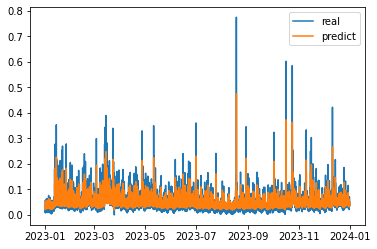

In [8]:
plt.plot(data.data_laundry['hour_e_time'], data.data_laundry['real'], label = 'real')
plt.plot(data.data_laundry['hour_e_time'], data.data_laundry['predict'], label = 'predict')
plt.legend()